# Modules Associated with Time Point

**Created**: 20 October 2021

## Environment

In [1]:
rm(list=ls())

library(tidyverse)
library(RColorBrewer)
library(cowplot)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [2]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)
variance.explained <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
sample.info <- sample.info %>% 
  dplyr::filter(supplier_name %in% rownames(eigengenes))
rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(eigengenes),]
sample.info <- sample.info %>%
  dplyr::mutate(Time.Point=as.numeric(sapply(strsplit(rownames(.), "_"), function(x) x[2])))

## Association with Time Point between D1-D5 Pairs

Some patients have provided samples at both D1 and D5. We can test if eigengenes are different between these timepoints.

I ran a Wilcox paired test with a two-sided alternative to test for a difference in module eigengenes across the twopoints. The p-values were adjusted using a Benjamini-Hochberg FDR correction.

In [4]:
d1.d5.pair <- sample.info %>%
  dplyr::select(GAinSID, Time.Point, supplier_name) %>%
  tidyr::spread(Time.Point, supplier_name) %>%
  dplyr::filter(!is.na(`1`) & !is.na(`5`)) %>%
  dplyr::select(GAinSID, D1=`1`, D5=`5`) %>%
  tidyr::gather("Time.Point", "Sample", -GAinSID)

d1.d5.vars <- eigengenes[d1.d5.pair$Sample,] %>%
  cbind(., d1.d5.pair) %>%
  as.data.frame() %>%
  dplyr::select(-Sample)

test.results <- list()
test.results[["P.Value"]] <- list()
test.results[["Median.Delta"]] <- list()

for (eigengene in variance.explained$Module) {

  paired.data <- d1.d5.vars %>%
    dplyr::select(one_of(eigengene), Time.Point, GAinSID) %>%
    tidyr::spread(Time.Point, eigengene) %>%
    dplyr::mutate(Delta=D5 - D1)
  
  test.results[["P.Value"]][[eigengene]] <- wilcox.test(paired.data$D1, paired.data$D5, paired=TRUE, alternative="two.sided")$p.value
  test.results[["Median.Delta"]][[eigengene]] <- median(paired.data$Delta)
}

associated.eigengenes <- lapply(test.results, unlist) %>%
  as.data.frame() %>%
  dplyr::mutate(Eigengene=rownames(.)) %>%
  dplyr::mutate(Adjusted.P.Value=p.adjust(P.Value, method="BH")) %>%
  dplyr::arrange(desc(abs(Median.Delta))) %>%
  dplyr::mutate(Association.Variable="D5 - D1", Association.Variable.Type="Time Point", Statistic.Type="Median Difference") %>%
  dplyr::select(Eigengene, Association.Variable, Association.Variable.Type, Statistic=Median.Delta, Statistic.Type, P.Value, Adjusted.P.Value)
print(associated.eigengenes %>% dplyr::filter(Adjusted.P.Value < 0.05))

write.csv(associated.eigengenes, "~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.time.point.association.csv")

       Eigengene Association.Variable Association.Variable.Type    Statistic
ME_9        ME_9              D5 - D1                Time Point -0.045470404
ME_22      ME_22              D5 - D1                Time Point -0.044200127
ME_40      ME_40              D5 - D1                Time Point -0.040583448
ME_51      ME_51              D5 - D1                Time Point -0.040087580
ME_16      ME_16              D5 - D1                Time Point -0.039951937
ME_61      ME_61              D5 - D1                Time Point -0.038240903
ME_26      ME_26              D5 - D1                Time Point -0.036771233
ME_56      ME_56              D5 - D1                Time Point -0.036421221
ME_65      ME_65              D5 - D1                Time Point -0.036398707
ME_23      ME_23              D5 - D1                Time Point -0.036302379
ME_29      ME_29              D5 - D1                Time Point -0.035400952
ME_74      ME_74              D5 - D1                Time Point -0.035336510

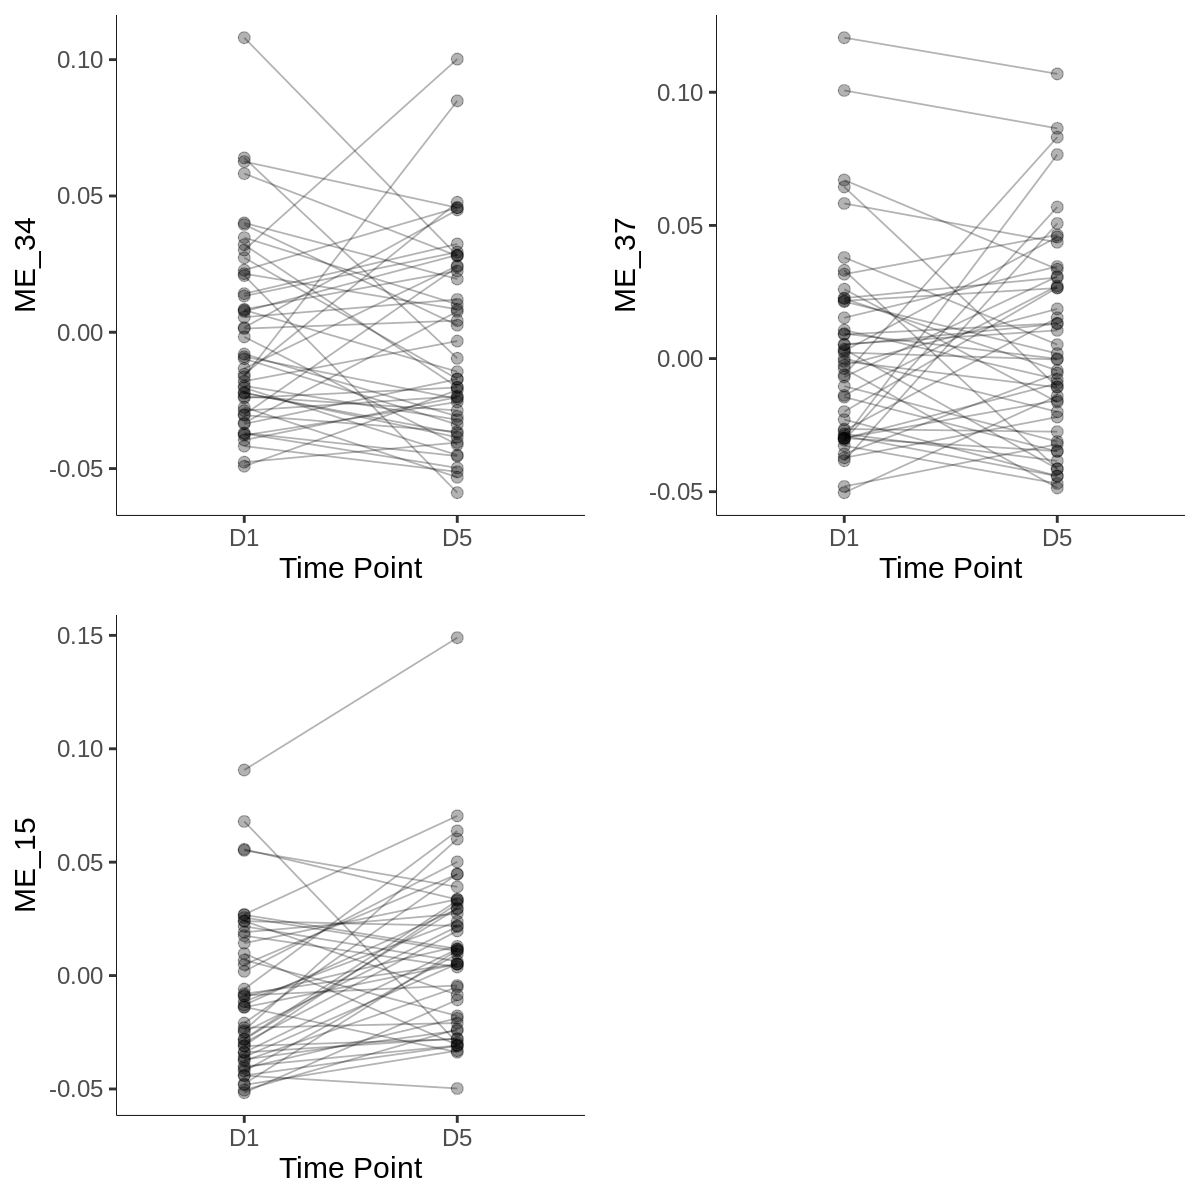

In [6]:
plots <- lapply(c("ME_34", "ME_37", "ME_15"), function(eigengene) {
  ggplot(d1.d5.vars, aes_string(x="Time.Point", y=eigengene, group="GAinSID")) +
    geom_line(alpha=0.3) +
    geom_point(size=I(3), alpha=0.3) +
    xlab("Time Point") +
    ggplot_theme
})

options(repr.plot.width=10, repr.plot.height=10)
cowplot::plot_grid(plotlist=plots)
ggsave("04_Expression/results/eigengene_association_with_time_point.svg", width=10, height=10)